# Non-local Means Implementation
- **Name - Rishi Sharma**
- **Roll No - 171CO135**

In this implementation, we will discuss the implementation of a famous denoising algorithm **Non Local Means**(*aka* **NLM**). We know that people love taking photos, but during the image acquisition process, image gets contaminated by noise. And this happens most of the time. There has been a lot of efforts to mitigate noise effects on images by means of filtering. Normally noise is highly noticeable in high frequencies, so low pass filters are normally used to mitigate undesired effects:

- Linear low pass filtering. The most common is the gaussian filter, but normally those filters also add some unwanted distortion around image edges and textures
- Non-linear filters. We find here the bilateral or the non local means filters, among others. The non linearity is introduced to avoid destroying image information at high frequencies
- Variational Methods. Namely the Rudin-Osher-Fatemi method, which attempts to approximate the original image by minimizing a energy method.

The list goes on and on. But the most famous and used algorithm is  **Non Local Means (NLM)**, mainly for two reasons:
 
- It gives one of the best results
- The idea is really simple but powerful

Let discuss the intuition behind the algorithm. The origin comes from the fact that in an image there is a lot of redundancy. For example in this image:

<img src="lena_marked.png" width="300px" height="300px">

The squares marked with the same color are on similar images areas. So, why not use all this information to infer values of the pixel? The idea comes from the Markov Random Field theory which, intuitively, claims that the $pdf$ of a pixel given it´s neighborhood should be similar for similar neighborhoods.

Essentially, the algorithm modifies each pixel value by a weighted average of all the other pixels, and the weight values are determined by neighborhood similarity:
\begin{equation}
\Large    I(p) = \frac{1}{Z}\sum_{q ∈ N} w_{pq}I(q) 
\end{equation}


The variable $Z = \sum w_{pq}$ is a normalization factor and $\cal{N}$ is a neighborhood around the pixel $p$. The weights $w_{pq}$ are computed as:
\begin{equation}
\Large\Large     w_{pq} = e^{\frac{−\mid \Omega(I(p))−\Omega(I(q)) \mid}{h^2}^2} 
\end{equation}

where $\Omega(x)$ indicates a winow centered on pixel $x$.

## Translating the above math equation into pseudo-code, we get:

    for x,y in Image:
      total_color = 0
      Z = 0    
      for xp,yp in BigNeighborhood(x,y):
            difference = norm(SmallNeighborhood(x,y) - SmallNeighborhood(xp,yp))
            w = exp(-difference/h^2)
            total_color = total_color + w*I(xp, yp)
      I(x,y) = color / Z

# Let's move-on to the implementation part 

## Importing the required libraries

In [3]:
import time
import warnings
import numpy as np
%matplotlib inline
import skimage.io as io
import skimage.color as color
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from skimage.transform import resize
from sklearn.decomposition import PCA
from functools import reduce, partial
from sklearn.neighbors.ball_tree import BallTree

## Loading images and adding Gaussian noise

In [4]:
#Loading Image
lena_image = io.ImageCollection('lena.png')[0].astype(np.float) / 255.0
lena_image = resize(lena_image, (lena_image.shape[0]//2, lena_image.shape[1]//2))
lena_image = color.rgb2lab(lena_image)
lena_image = lena_image[:,:,0]

#Adding Gaussian Noise to Image
sigmas = [5, 10, 15, 20, 25]
noisy = []
for sigma in sigmas:
    noise = sigma*np.random.rand(*lena_image.shape)
    n = lena_image + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)

## Let's have a look at the images

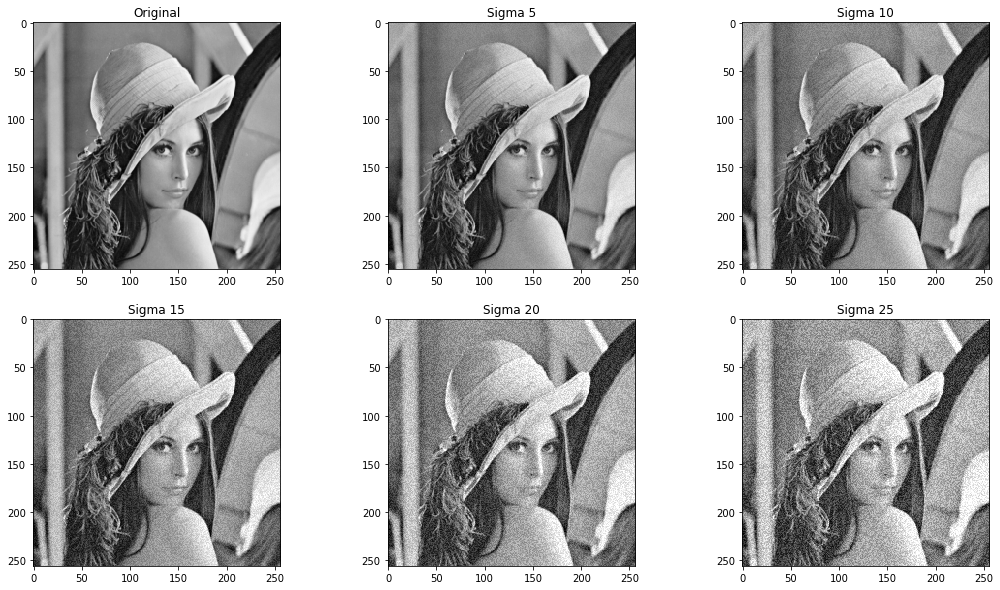

In [5]:
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.imshow(lena_image, cmap='gray')
plt.title("Original")
for i,n in enumerate(noisy):
    plt.subplot(2,3,i+2)
    plt.title("Sigma "+str(5*(i+1)))
    plt.imshow(n,cmap='gray')

## Measuring image quality

Before digging into the actual problem, we need a measure to know the performance of our algorithm. Althought there is a lot of measures out there to measure image quality, we will stick with the **PSNR** i.e., **Peak to signal ratio**:
\begin{equation}
\Large PSNR(I_{0}, I) = 10\log\frac{MAX^2}{MSE(I_{0}, I)}
\end{equation}
Where $I_0$ is our original image and $I$ is the denoised image. $MAX$ is the maxmimum value the signal can get and  $MSE$ is mean squared error between images $I_0$ and  $I$

## Let's have look at the code of PSNR

In [6]:
def PSNR(original, noisy, peak=100):
    mse = np.mean((original-noisy)**2)
    return 10*np.log10(peak*peak/mse)

## Below are shown several images with differents amount of noise:

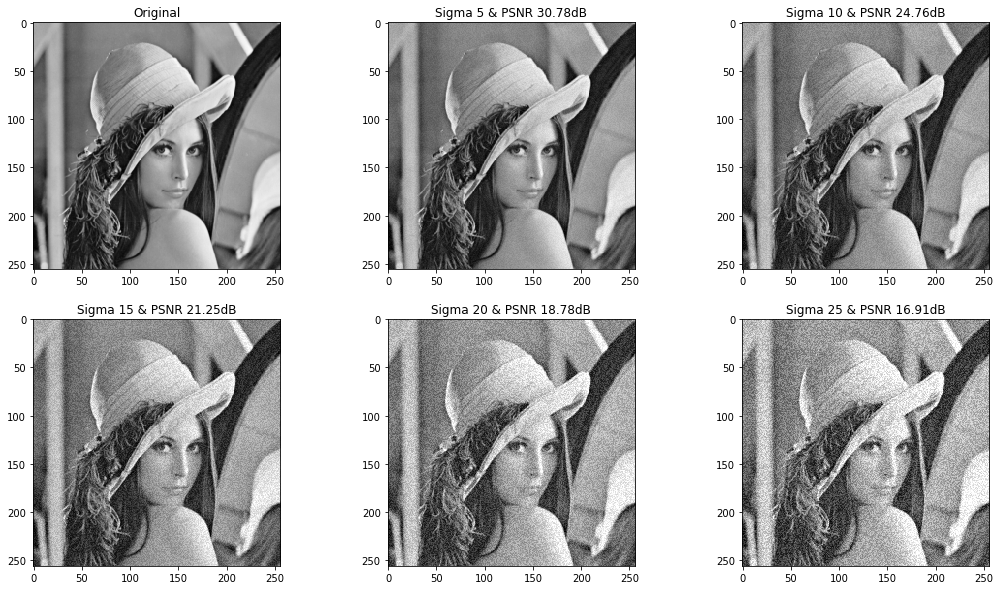

In [7]:
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.imshow(lena_image, cmap='gray')
plt.title("Original")
for i,n in enumerate(noisy):
    plt.subplot(2,3,i+2)
    plt.title("Sigma "+str(5*(i+1))+" & PSNR {0:.2f}dB".format(PSNR(lena_image, n)))
    plt.imshow(n,cmap='gray')

# NLM Implementation 1

Following the algorithm definition, we can translate directly the NLM maths to real code, by doing:

- Loop over each pixel $p$
- For each $p$ loop over all other pixels $q$ to compare patches
- Compute each patch centered at $q$ to a patch centered $p$
- Weight each patch accordingly and compute the weighted mean

There is mainly one big issue with this approach: the run time. For a $N\times M$ image, the naive implementation runs in $O(N^4D^2)$ where $D$ is the width of the patches we are comparing. This is clearly not feasible for even medium-sized images.

A trivial solution is to limit the search space on $q$ and, instead of looping over the whole image, just look for similar patches in a window of size $W$. Then the algorithm runs in $O(N^2W^2D^2)$ which is not too bad, but it can still give you high processing times for a single image.

The metric used to compare the similarity between the patches in this implementation(**NLM1**) is **Eucledian distance**

### **Eucledian Distance** is calculated as:
\begin{equation}
\Large dist(x, y) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
\end{equation}

## Function for calculating Eucledian Distance between two patches

In [9]:
def eucledian_distance(values, pixel_window, h2, Nw):
    patch_window, central_diff = values

    diff = np.sum((pixel_window - patch_window) ** 2)
    
    # remove the central distance from the computation
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    # return the color of the pixel and the weight associated with the patch
    nr, nc = patch_window.shape
    return w * patch_window[nr // 2, nc // 2], w

## Implementing NLM 1

In [10]:
def naive_NLM_1(img, n_big=20, n_small=5, h=10):
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    D = range(-n_big, n_big + 1)
    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    # precompute coordinate difference for the small patch
    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small
    n_padded = np.pad(img, padding, mode='reflect')

    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            pixel_window = n_padded[small_rows + r, small_cols + c]

            # construct a list of patch_windows
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            # construct a list of central differences
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]

            distance_map = partial(eucledian_distance, pixel_window=pixel_window, h2=h2, Nw=Nw)
            distances = map(distance_map, zip(windows, central_diffs))

            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            new_n[r - padding, c - padding] = total_c // total_w

    return new_n

## Let's talk about the parameters of the above implementation of NLM

All the above is what we really need to denoise an image using NLM. The parameters of the algorithms are **n_big**, **n_small** and **h**.

- **n_big**: related to the big neighborhood to search for patches. The bigger, the better, but more CPU is needed.
- **n_small**: related to the patch size when comparing similar neighborhoods. Here we should find a compromise between CPU and signal stationarity. We can´t chose a very big patch because all patches will be different. We cannot choose a small patch either, because otherwise all patches will be similar. Normal values can range from 3 to 10.
- **h**: this is the constant used to control patch difference. It is known that it is closely related to the noise variance $\sigma^2$ present on image, and it may depend from pixel to pixel. Normally it is set at $K\sigma$ where K is $(7,10)$. The larger the value of h, more smoother the denoised image will be.

Here we know the amount the noise we have on each image, but normally this is not the case. We, however, can produce a rough noise estimate $\widehat{\sigma}$by trying to predict an optimal linear low pass filter that minimizes the square error. Since we know that a linear low pass filter will treat high "legitimate" high frequencies as noise, and thus $\widehat{\sigma} > \sigma$, we will then set $h=2*\widehat{\sigma}$.


## Applying NLM 1

PSNR before 30.7840 - PSNR after denoising 29.2517 - time taken 218.3 secs
PSNR before 24.7603 - PSNR after denoising 24.2247 - time taken 214.9 secs
PSNR before 21.2459 - PSNR after denoising 21.0690 - time taken 214.2 secs
PSNR before 18.7777 - PSNR after denoising 18.8689 - time taken 214.0 secs
PSNR before 16.9102 - PSNR after denoising 17.2238 - time taken 215.0 secs


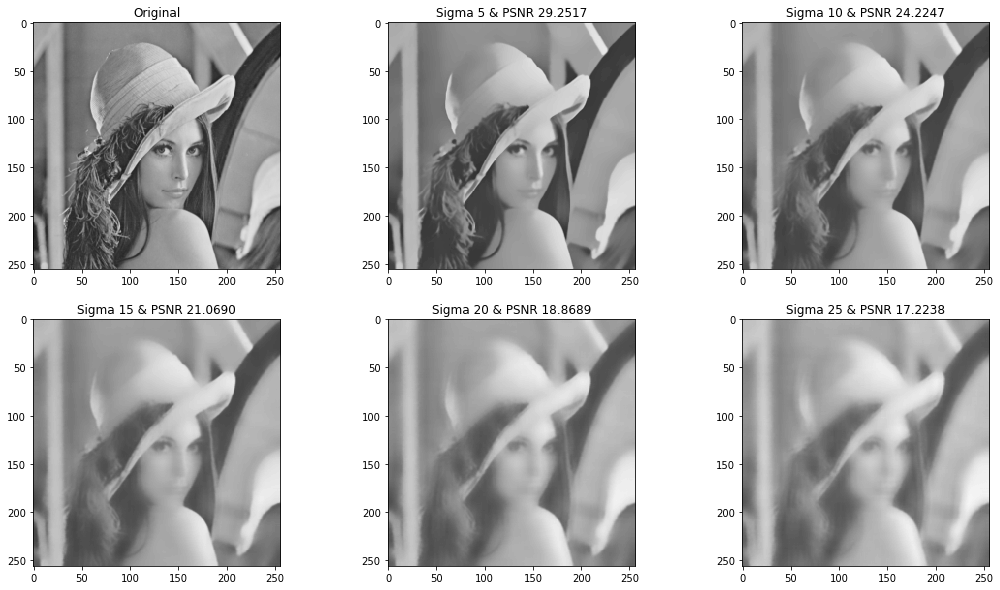

In [11]:
denoised_naive = []
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena_image, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = naive_NLM_1(noisy[i], n_big=7, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(lena_image, noisy[i])
    dPSNR = PSNR(lena_image, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - time taken {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("Sigma "+str(5*(i+1))+" & PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

We can see that, it seems our filter has some problems when noise is high.

# NLM Implementation 2

In the above algorithm, to compare the similarity of the patches we used **Eucledian Distance** between pixels but in this algorithm we will use another metrics so comparing the similarity betweent the patches. We will use **Manhattan Distance** as a metric for comparison between the patches.

### Manhanttan Distance is calculated as:
\begin{equation}
\Large dist(x, y)   = \mid x_1 - x_2 \mid + \mid y_1 - y_2 \mid
\end{equation}

## Function for computing Manhattan Distance between two patches

In [20]:
def manhattan_distance(values, pixel_window, h2, Nw):
    patch_window, central_diff = values
    
    #computing the manhattan distance
    diff = np.sum(np.abs(pixel_window - patch_window))
    
    # remove the central distance from the computation
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    # return the color of the pixel and the weight associated with the patch
    nr, nc = patch_window.shape
    return w * patch_window[nr // 2, nc // 2], w

## Implementing NLM 2

In [21]:
def naive_NLM_2(img, n_big=20, n_small=5, h=10):
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    h2 = h*h
    n_rows, n_cols = img.shape
    # precompute the coordinate difference for the big patch
    D = range(-n_big, n_big + 1)
    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    # precompute coordinate difference for the small patch
    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small
    n_padded = np.pad(img, padding, mode='reflect')

    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            pixel_window = n_padded[small_rows + r, small_cols + c]

            # construct a list of patch_windows
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            # construct a list of central differences
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]

            distance_map = partial(manhattan_distance, pixel_window=pixel_window, h2=h2, Nw=Nw)
            distances = map(distance_map, zip(windows, central_diffs))

            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            new_n[r - padding, c - padding] = total_c // total_w

    return new_n

## Applying NLM 2

PSNR before 25.9906 - PSNR after denoising 22.3702 - time taken 231.9 secs
PSNR before 20.0369 - PSNR after denoising 21.6465 - time taken 218.3 secs
PSNR before 16.7002 - PSNR after denoising 21.4567 - time taken 221.3 secs
PSNR before 14.4178 - PSNR after denoising 21.2628 - time taken 238.4 secs
PSNR before 12.8346 - PSNR after denoising 21.0117 - time taken 240.0 secs


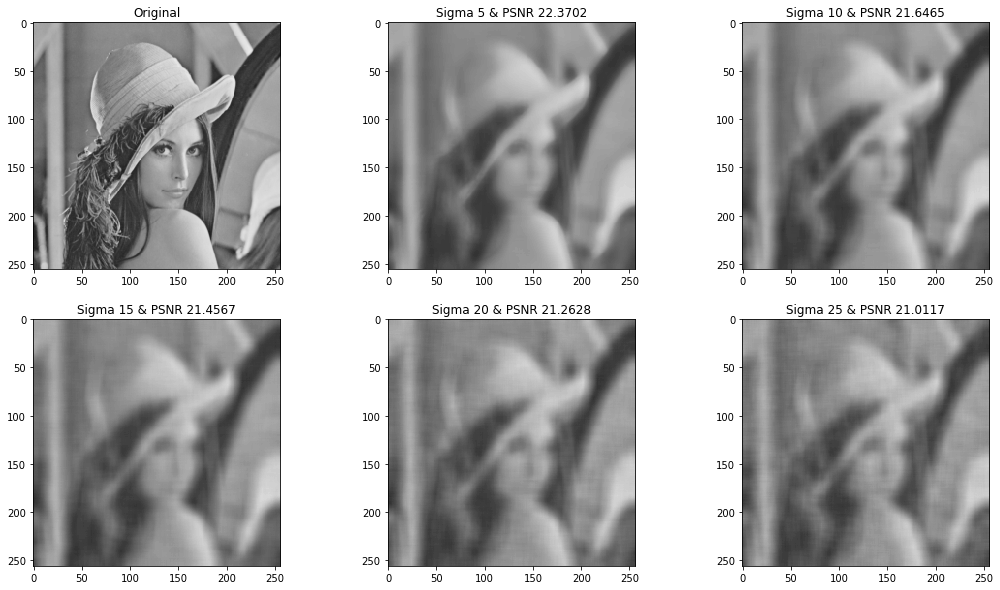

In [22]:
#Loading Image
lena_image = io.ImageCollection('lena.png')[0].astype(np.float) / 255.0
lena_image = resize(lena_image, (lena_image.shape[0]//2, lena_image.shape[1]//2))
lena_image = color.rgb2lab(lena_image)
lena_image = lena_image[:,:,0]

#Adding Gaussian Noise to Image
sigmas = [5, 10, 15, 20, 25]
noisy = []
for sigma in sigmas:
    noise = sigma*np.random.randn(*lena_image.shape)
    n = lena_image + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)
    

denoised_naive = []
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena_image, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = naive_NLM_2(noisy[i], n_big=7, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(lena_image, noisy[i])
    dPSNR = PSNR(lena_image, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - time taken {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("Sigma "+str(5*(i+1))+" & PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

# NLM Implementation 3

In the above algorithm, to compare the similarity of the patches we used **Eucledian Distance** between pixels but in this algorithm we will use another metrics so comparing the similarity betweent the patches. We will use **Minkowski Distance** as a metric for comparison between the patches.

### Minkowski Distance is calculated as:
\begin{equation}
\Large dist(x, y)   = \qquad \sqrt[\leftroot{-1}\uproot{2}\scriptstyle p]{(x_1 - x_2)^p + (y_1 - y_2)^p}\qquad
\end{equation}

## Function for computing Minkowski Distance(p = 7) between two patches

In [14]:
def minkowski_distance(values, pixel_window, h2, Nw, p):
    patch_window, central_diff = values
    
    #computing the minkowski distance
    diff = (np.sum(np.abs(pixel_window - patch_window)**p))**(1/p)
    
    # remove the central distance from the computation
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    # return the color of the pixel and the weight associated with the patch
    nr, nc = patch_window.shape
    return w * patch_window[nr // 2, nc // 2], w

## Implementing NLM 3

In [18]:
def naive_NLM_3(img, n_big=20, n_small=5, h=10, p=2):
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    h2 = h*h
    n_rows, n_cols = img.shape
    # precompute the coordinate difference for the big patch
    D = range(-n_big, n_big + 1)
    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    # precompute coordinate difference for the small patch
    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small
    n_padded = np.pad(img, padding, mode='reflect')

    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            pixel_window = n_padded[small_rows + r, small_cols + c]

            # construct a list of patch_windows
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            # construct a list of central differences
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]

            distance_map = partial(minkowski_distance, pixel_window=pixel_window, h2=h2, Nw=Nw, p=p)
            distances = map(distance_map, zip(windows, central_diffs))

            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            new_n[r - padding, c - padding] = total_c // total_w

    return new_n

## Applying NLM 3

PSNR before 25.9662 - PSNR after denoising 31.9983 - time taken 240.9 secs
PSNR before 20.0556 - PSNR after denoising 28.4456 - time taken 230.3 secs
PSNR before 16.6467 - PSNR after denoising 26.0599 - time taken 235.1 secs
PSNR before 14.4605 - PSNR after denoising 24.2123 - time taken 231.3 secs
PSNR before 12.8328 - PSNR after denoising 22.7990 - time taken 227.7 secs


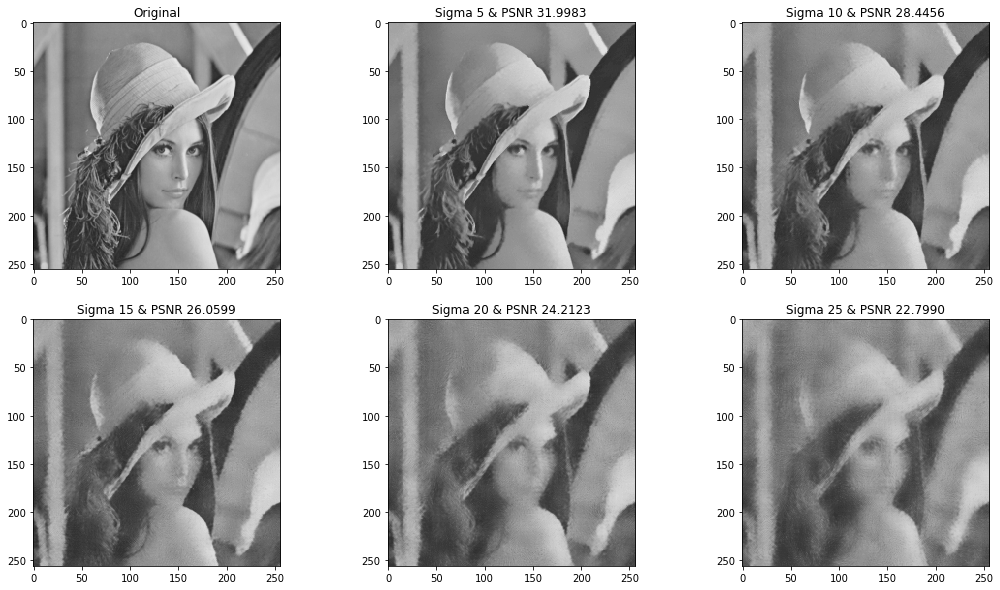

In [16]:
#Loading Image
lena_image = io.ImageCollection('lena.png')[0].astype(np.float) / 255.0
lena_image = resize(lena_image, (lena_image.shape[0]//2, lena_image.shape[1]//2))
lena_image = color.rgb2lab(lena_image)
lena_image = lena_image[:,:,0]

#Adding Gaussian Noise to Image
sigmas = [5, 10, 15, 20, 25]
noisy = []
for sigma in sigmas:
    noise = sigma*np.random.randn(*lena_image.shape)
    n = lena_image + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)
    

denoised_naive = []
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena_image, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = naive_NLM_3(noisy[i], n_big=7, n_small=1, h=2*sigmas[i], p=7)
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(lena_image, noisy[i])
    dPSNR = PSNR(lena_image, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - time taken {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("Sigma "+str(5*(i+1))+" & PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

# NLM Implementation 4

As we have seen in the above algorithms that they work well, when the noise level is less but as the level of noise increases the **PSNR** becomes less, hence the denoised image has less quality when noise is more as compared to when noise is less. 

First, ideally we should search the whole image to find enough similar patches to estimate a pixel's new color. But we know that we need to restrict the neighborhood because a complete search is infeasible. It would be nice if we could search globally and fast.

The proposed algorithm here is to index all possible image patches efficiently. Essentially, we are going to:

- Get all the patches for the image
- Compute their PCA so we know which patch shapes are more descriptive than the others
- Since low-importance components are more likely to be related to noise, we can discard most of them. We reduce a patch from $W^2$ components to a much smaller number (we use 9, but it can be changed).
- Index all the reduced patch vectors in a binary search tree-like structure like a ball tree.

By using this, we can then find the **K-nearest neighbors** of a single patch much more quickly and in the whole image!

But there is question why **PCA** and the answer is if we want to search through the whole image and also want to do it fast then we have to apply **Dimensionality Reduction** and **PCA** is one of the most common **Dimensionality Reduction** algorithm and is easily available in libraries which we can use here directly.

## Implementing NML 4

In [24]:
def clustered_nlm_4(img, n_small=5, n_components=9, n_neighbors=30, h=10):

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    small_rows, small_cols = np.indices(((2 * n_small + 1), (2 * n_small + 1))) - n_small

    # put all patches so we can cluster them
    n_padded = np.pad(img, n_small, mode='reflect')
    patches = np.zeros((n_rows * n_cols, Nw))

    n = 0
    for r in range(n_small, n_small + n_rows):
        for c in range(n_small, n_small + n_cols):
            window = n_padded[r + small_rows, c + small_cols].flatten()
            patches[n, :] = window
            n += 1

    transformed = PCA(n_components=n_components).fit_transform(patches)
    # index the patches into a tree
    tree = BallTree(transformed, leaf_size=2)
    new_img = np.zeros_like(img)
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            dist, ind = tree.query(transformed[idx].reshape(1, -1), k=n_neighbors)
            ridx = np.array([(int(i / n_cols), int(i % n_cols)) for i in ind[0, 1:]])
            colors = img[ridx[:, 0], ridx[:, 1]]
            w = np.exp(-dist[0, 1:] / h2)
            new_img[r, c] = np.sum(w * colors) / np.sum(w)

    return new_img

## Applying NLM 4

PSNR before 26.0307 - PSNR after denoising 27.3481 - time taken 32.1 secs
PSNR before 20.0292 - PSNR after denoising 26.7591 - time taken 34.7 secs
PSNR before 16.6962 - PSNR after denoising 25.8564 - time taken 33.9 secs
PSNR before 14.4139 - PSNR after denoising 24.8934 - time taken 34.9 secs
PSNR before 12.8290 - PSNR after denoising 24.0366 - time taken 36.2 secs


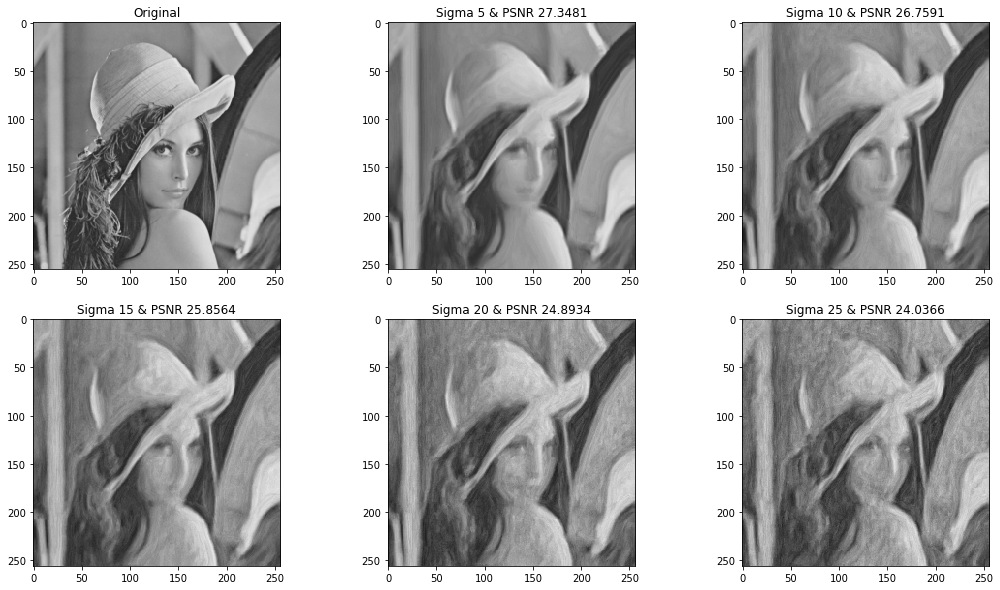

In [25]:
#Loading Image
lena_image = io.ImageCollection('lena.png')[0].astype(np.float) / 255.0
lena_image = resize(lena_image, (lena_image.shape[0]//2, lena_image.shape[1]//2))
lena_image = color.rgb2lab(lena_image)
lena_image = lena_image[:,:,0]

#Adding Gaussian Noise to Image
sigmas = [5, 10, 15, 20, 25]
noisy = []
for sigma in sigmas:
    noise = sigma*np.random.randn(*lena_image.shape)
    n = lena_image + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)
    

denoised_clustered = []
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena_image, vmin=0, vmax=100, cmap='gray')

for i,n in enumerate(noisy):
    start = time.time()
    denoised = clustered_nlm_4(noisy[i], n_neighbors=40, n_small=10, h=3*sigmas[i], n_components=9)
    end = time.time()
    secs = end-start
    denoised_clustered.append(denoised)
    oPSNR = PSNR(lena_image, noisy[i])
    dPSNR = PSNR(lena_image, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - time taken {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("Sigma "+str(5*(i+1))+" & PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

# NLM Implementation 5

## Implementing NLM 5

In [26]:
def nlm_5(X, N, K, sigma):
    H, W = X.shape
    pad_len = N+K
    Xpad=np.pad(X,pad_len,'constant',constant_values=0)

    yy = np.zeros(X.shape)
    B = np.zeros([H, W])

    for ny in range(-N, N + 1):
        for nx in range(-N, N + 1):
            # compute neighborhood difference by looping through kernel
            # array to hold values to calculate SSD
            ssd = np.zeros((H,W))
            for ky in range(-K, K + 1):
                for kx in range(-K, K + 1):
                    ssd += np.square(
                        Xpad[pad_len+ny+ky:H+pad_len+ny+ky,pad_len+nx+kx:W+pad_len+nx+kx]
                        - Xpad[pad_len+ky:H+pad_len+ky,pad_len+kx:W+pad_len+kx])
            # compute differnce for these set of neighborhood pixels
            ex = np.exp(-ssd/(2*sigma**2))
            B += ex
            yy += ex * Xpad[pad_len+ny:H+pad_len+ny,pad_len+nx:W+pad_len+nx]

    return yy / B

## Applying NLM 5

PSNR before 26.0169 - PSNR after denoising 27.4089 - time taken 1.1 secs
PSNR before 20.0692 - PSNR after denoising 26.7417 - time taken 1.2 secs
PSNR before 16.6516 - PSNR after denoising 25.7337 - time taken 1.1 secs
PSNR before 14.4535 - PSNR after denoising 24.5058 - time taken 1.0 secs
PSNR before 12.8394 - PSNR after denoising 23.1838 - time taken 2.2 secs


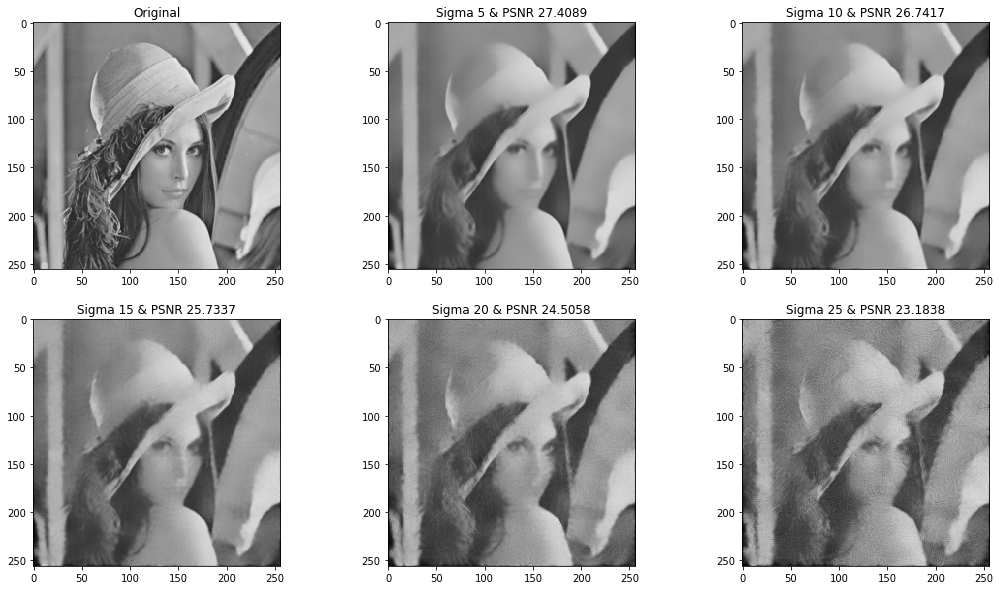

In [27]:
#Loading Image
lena_image = io.ImageCollection('lena.png')[0].astype(np.float) / 255.0
lena_image = resize(lena_image, (lena_image.shape[0]//2, lena_image.shape[1]//2))
lena_image = color.rgb2lab(lena_image)
lena_image = lena_image[:,:,0]


#Adding Gaussian Noise to Image
sigmas = [5, 10, 15, 20, 25]
noisy = []
for sigma in sigmas:
    noise = sigma*np.random.randn(*lena_image.shape)
    n = lena_image + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)

denoised_clustered = []
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena_image, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nlm_5(noisy[i], 8, 2, 2.8*np.std(noisy[i]))
    end = time.time()
    secs = end-start
    denoised_clustered.append(denoised)
    oPSNR = PSNR(lena_image, noisy[i])
    dPSNR = PSNR(lena_image, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - time taken {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("Sigma "+str(5*(i+1))+" & PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

# Analysis of various NLMs

## Analysing NLMs based on time taken

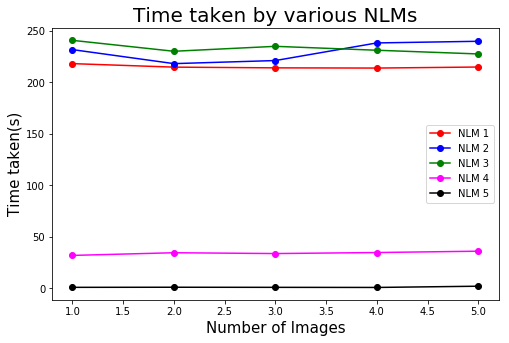

In [74]:
time_taken_1 = [218.3, 214.9, 214.2, 214.0, 215.0]
time_taken_2 = [231.9, 218.3, 221.3, 238.4, 240.0]
time_taken_3 = [240.9, 230.3, 235.1, 231.3, 227.7]
time_taken_4 = [32.1, 34.7, 33.9, 34.9, 36.2]
time_taken_5 = [1.1, 1.2, 1.1, 1.0, 2.2]

plt.figure(figsize=(8, 5))
plt.plot([i for i in range(1, 6)], time_taken_1, marker='o', label='NLM 1', color='red')
plt.plot([i for i in range(1, 6)], time_taken_2, marker='o', label='NLM 2', color='blue')
plt.plot([i for i in range(1, 6)], time_taken_3, marker='o', label='NLM 3', color='green')
plt.plot([i for i in range(1, 6)], time_taken_4, marker='o', label='NLM 4', color='magenta')
plt.plot([i for i in range(1, 6)], time_taken_5, marker='o', label='NLM 5', color='black')
plt.legend(fontsize=10)
plt.xlabel("Number of Images", fontsize=15)
plt.ylabel("Time taken(s)", fontsize=15)
plt.title("Time taken by various NLMs", fontsize=20)
plt.show()

### NLM 1
Time taken is around 215 secs for each image.

### NLM 2
Time taken is around 225 secs for each image.

### NLM 3
Time taken is around 235 secs for each image.

### NLM 4
Time taken is around 33 secs for each image.

### NLM 5
Time taken is around 1.2 secs for each image.

We can clearly see that NLM 5 is best in terms of time taken while **NLM 3** is worst, takes the most time to give the r**esults. Time taken by **NLM 1** is extremely less for each image it takes only 1 sec while **NLM 1, NLM 2, NLM 3** takes around 4 min to do the same.


After analysing the time taken we can say that **NLM 1** takes the least time and is best while **NLM 3** is worst as it takes much more than others.

## Analysing NLMs based on the **PSNR** ratio

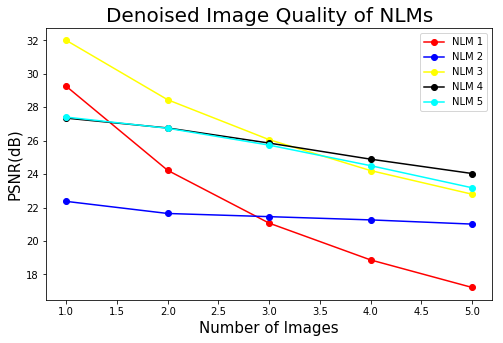

In [78]:
PSNR_after_denoising_1 = [29.2517, 24.2247, 21.0690, 18.8689, 17.2238]
PSNR_after_denoising_2 = [22.3702, 21.6465, 21.4567, 21.2628, 21.0117]
PSNR_after_denoising_3 = [31.9983, 28.4456, 26.0599, 24.2123, 22.7990]
PSNR_after_denoising_4 = [27.3481, 26.7591, 25.8564, 24.8934, 24.0366]
PSNR_after_denoising_5 = [27.4089, 26.7417, 25.7337, 24.5058, 23.1838]

plt.figure(figsize=(8, 5))
plt.plot([i for i in range(1, 6)], PSNR_after_denoising_1, marker='o', label='NLM 1', color='red')
plt.plot([i for i in range(1, 6)], PSNR_after_denoising_2, marker='o', label='NLM 2', color='blue')
plt.plot([i for i in range(1, 6)], PSNR_after_denoising_3, marker='o', label='NLM 3', color='yellow')
plt.plot([i for i in range(1, 6)], PSNR_after_denoising_4, marker='o', label='NLM 4', color='black')
plt.plot([i for i in range(1, 6)], PSNR_after_denoising_5, marker='o', label='NLM 5', color='cyan')
plt.legend(fontsize=10)
plt.xlabel("Number of Images", fontsize=15)
plt.ylabel("PSNR(dB)", fontsize=15)
plt.title("Denoised Image Quality of NLMs", fontsize=20)
plt.show()

### NLM 1
We can see that this NLM works better when the level of noise in the image is less but as the level of noise increases the quality of denoised image decreases and perform worst of all alogithms.

### NLM 2
In this NLM it is clearly visible that whether the level of noise is low or high PSNR value remains nearly same.

### NLM 3
We can clearly see that this NLM too works way better than others when the level of noise in the image is less but as the level of noise increases the quality of denoised image decreases graudally.

### NLM 4 & 5
We can clearly see that both of these these NLMs performs similar whether the noise level is high or low. 

After analysing the PSNR ratio of all algorithms we can say that when noise level is less in the image, NLM 3 performs best while when noise level is high then NLM 4 performs best.

# Conclusion

If we take both **time taken** and **PSNR** into consideration, if the level of noise is less in the image then **NLM 3** peforms better than others for denoising the image. But if level of noise is more in the image then **NLM 4** and **NLM 5** performs better than others. In terms of time taken **NLM 5** surpasses all of them and is around **200** times faster than **NLM 1, NLM 2, NLM 3** and **30** times faster than **NLM 4** hence is best can be made even better after tuning the values of N and K.